In [1]:
import sys,os
__script_path=os.path.abspath(globals().get('__file__','.'))
__script_dir = os.path.dirname(__script_path)
root_dir = os.path.abspath(f'{__script_dir}/..')
print(root_dir)
for lib in [root_dir][::-1]:
    if lib in sys.path:
        sys.path.remove(lib)
    sys.path.insert(0,lib)



d:\AIDU\flower_classification


In [2]:
from libs.common import *
from config.config import *
from utils.utils import load_data, flower_labels, view_hist_data,view_images
import matplotlib.pyplot as plt

d:/AIDU/flower_classification


In [3]:
%reload_ext autoreload
%autoreload 2

In [4]:
# data_dir="../../data"
# exps_dir = "../../exps"
if os.path.exists(exps_dir) == False: # tạo thư mục (nếu chưa có)
  os.makedirs(exps_dir, exist_ok=True)

save_dir = f"{exps_dir}/feature"
os.makedirs(save_dir, exist_ok=True)
test_size=0.33
seed=42

In [5]:
from config.config import *
from utils.utils import processing_data

# csv_path = os.path.join(dataset_dir, "fer2013", "fer2013.csv")
# output_dir = os.path.join(data_dir, "preprocessing")
# processing_data(csv_path, output_dir)

In [6]:
from config.config import *
from utils.utils import load_data, flower_labels, view_hist_data,view_images, boxPlot
import matplotlib.pyplot as plt
from models.models import VGG16, RESNET50, build_common_model
from tensorflow.keras import backend as K
# K.set_image_data_format('channels_last')



In [7]:
train_path = os.path.join(data_dir, "train.csv").replace("\\", "/")
test_path = os.path.join(data_dir, "val.csv").replace("\\", "/")
# test_path = os.path.join(data_dir, "preprocessing", "test.npz")
print(train_path)

d:/AIDU/flower_classification/data/train.csv


In [8]:
(x_train, y_train), (x_test, y_test)= load_data(train_path, test_path)

Read train data:  d:/AIDU/flower_classification/data/train.csv
['train/carnation/6838762136_f8254d6a1a_c.jpg'
 'train/carnation/3540544866_823aee81af_c.jpg'
 'train/carnation/50034862576_b0f55b7b3b_c.jpg' ...
 'train/common_daisy/26267498316_8ed1c153b4_c.jpg'
 'train/common_daisy/50560319813_debdfea05e_c.jpg'
 'train/common_daisy/7462259536_7f096c222f_c.jpg']
Read valid data:  d:/AIDU/flower_classification/data/val.csv


train/carnation/6838762136_f8254d6a1a_c.jpg
Training images:  13642  - shape:  (256, 256, 3)
Validating images:  98  - shape:  (256, 256, 3)


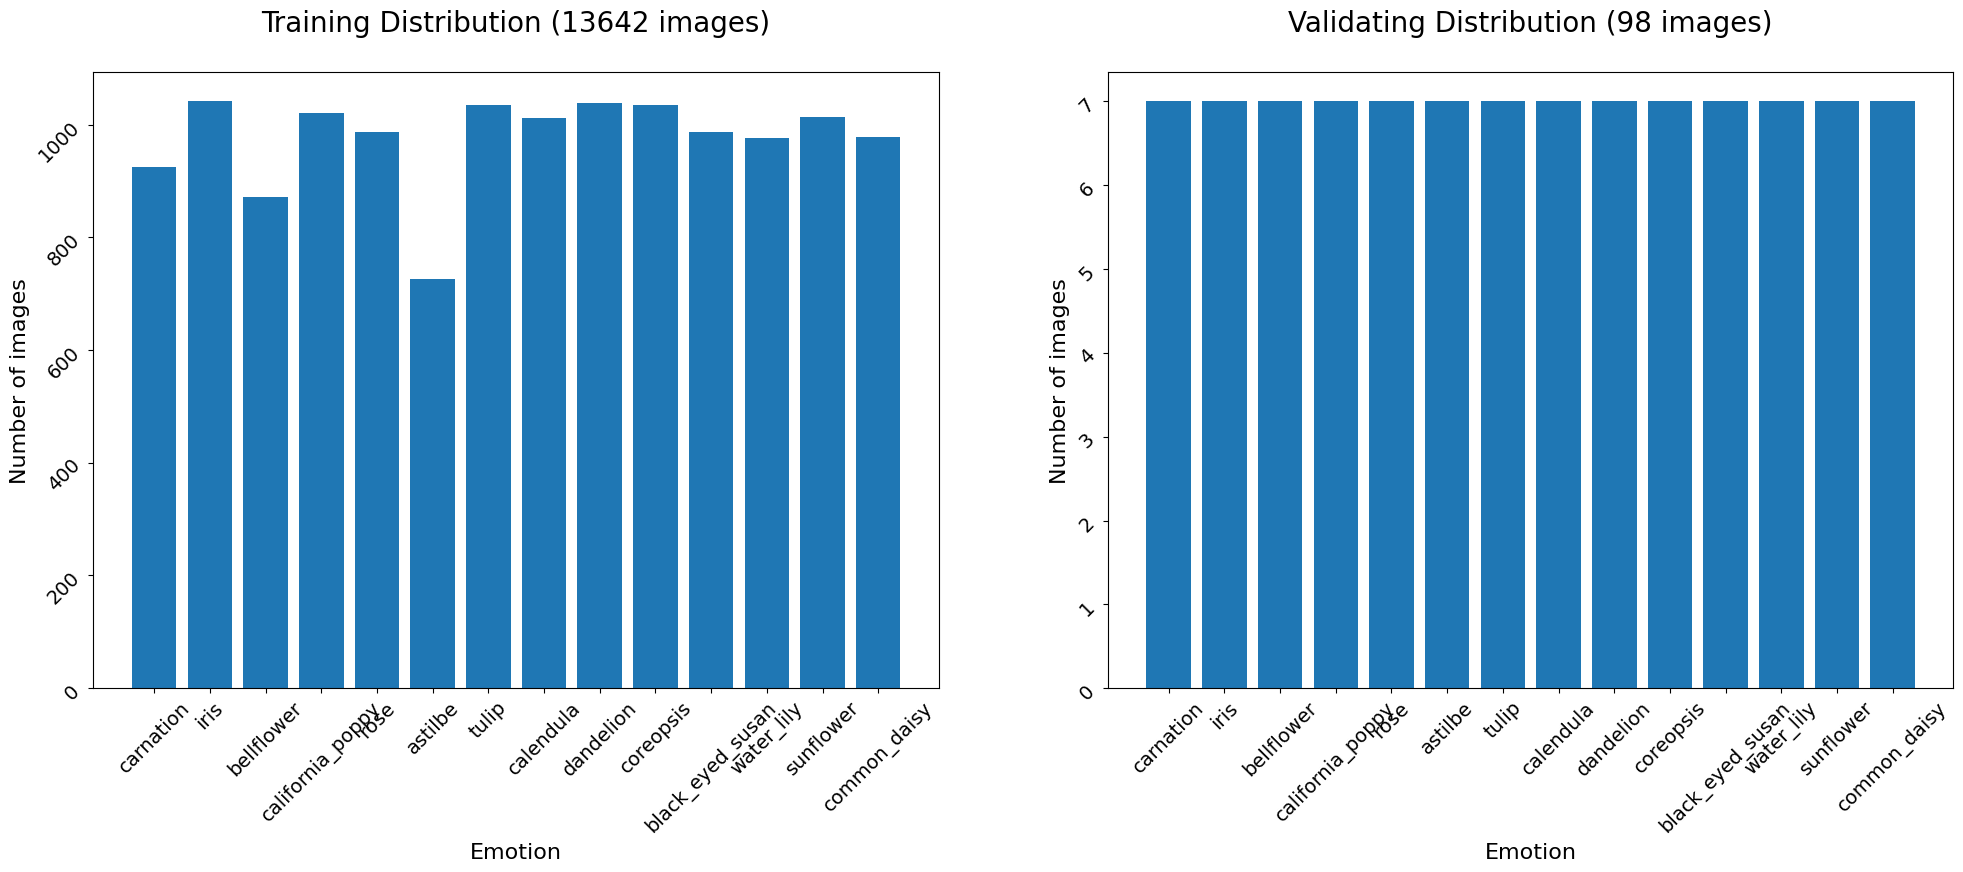

In [9]:
view_hist_data(x_train, y_train, x_test, y_test, save_path = f'{save_dir}/distribution.png')

Sample training images


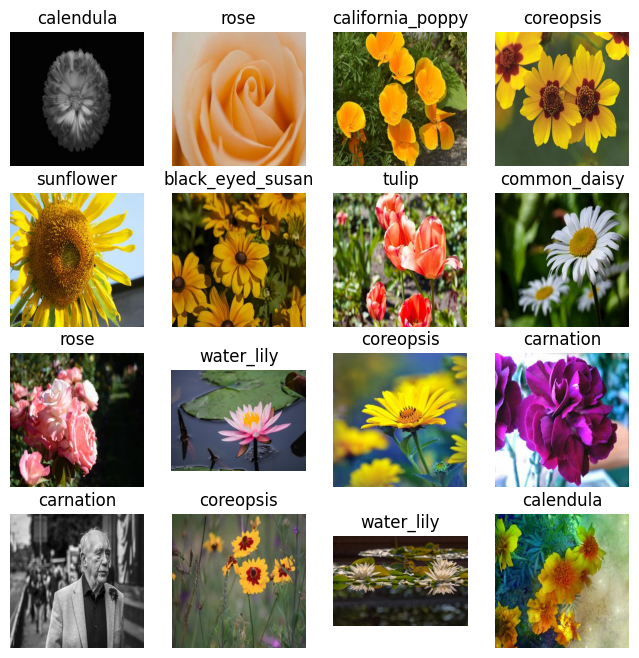

Sample Test images


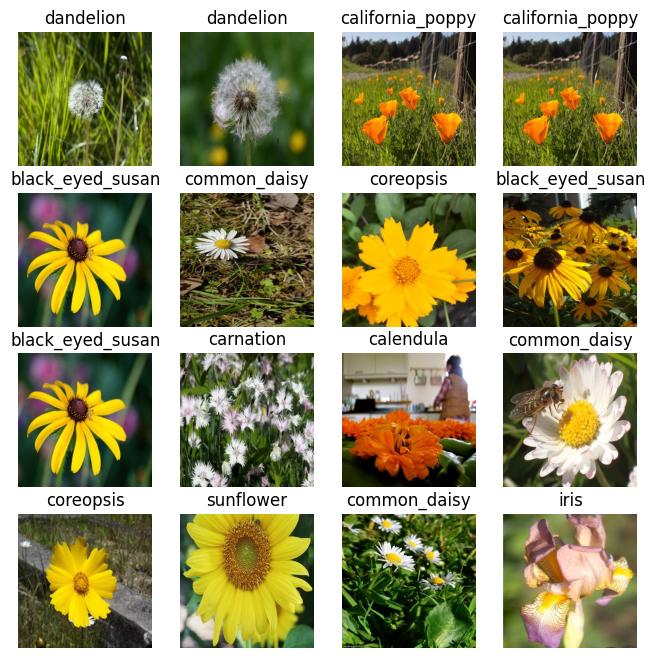

In [10]:
print("Sample training images")
view_images(x_train, y_train, None, rows = 4, cols = 4, figsize = (8, 8), 
            save_path = f'{save_dir}/sample_training_images.png')

print("Sample Test images")
view_images(x_test, y_test, None, rows = 4, cols = 4, figsize = (8, 8), 
            save_path = f'{save_dir}/sample_validating_images.png')



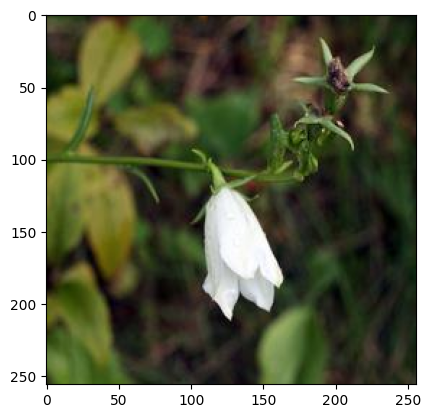

In [11]:
flow1 = cv2.imread(f'{data_dir}/train/bellflower/48917780_834f0a1ce3_c.jpg')
flow1 = cv2.cvtColor(flow1,cv2.COLOR_BGR2RGB)
plt.imshow(flow1)

In [12]:
image_gen = ImageDataGenerator(rotation_range=30, 
                               width_shift_range=0.1,
                               height_shift_range=0.1, 
                               rescale=1/255, 
                               shear_range=0.2, 
                               zoom_range=0.2, 
                               horizontal_flip=True, 
                               fill_mode='nearest', 
                               validation_split=0.2
                              )

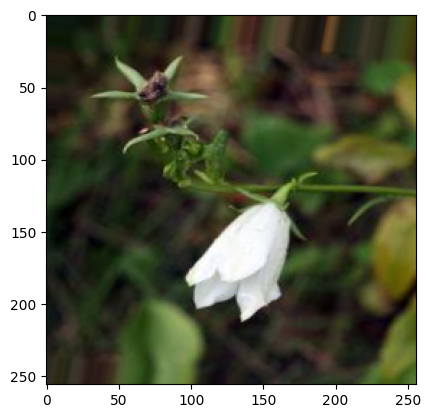

In [13]:
plt.imshow(image_gen.random_transform(flow1))

In [14]:
batch_size = 64
target_size = (224,224)
train_image_gen = image_gen.flow_from_directory(f'{data_dir}/train',
                                               target_size=target_size,
                                               batch_size=batch_size,
                                               class_mode='categorical',
                                               subset='training')

Found 10919 images belonging to 14 classes.


In [15]:
valid_image_gen = image_gen.flow_from_directory(f'{data_dir}/train',
                                               target_size=target_size,
                                               batch_size=batch_size,
                                               class_mode='categorical',
                                               subset='validation')

Found 2723 images belonging to 14 classes.


In [16]:
train_image_gen.class_indices

{'astilbe': 0,
 'bellflower': 1,
 'black_eyed_susan': 2,
 'calendula': 3,
 'california_poppy': 4,
 'carnation': 5,
 'common_daisy': 6,
 'coreopsis': 7,
 'dandelion': 8,
 'iris': 9,
 'rose': 10,
 'sunflower': 11,
 'tulip': 12,
 'water_lily': 13}

In [17]:
current_class_indices = train_image_gen.class_indices

desired_order = ["carnation", "iris", "bellflower", "california_poppy", "rose", "astilbe", 
                 "tulip", "calendula", "dandelion", "coreopsis", "black_eyed_susan", 
                 "water_lily", "sunflower", "common_daisy"]

sorted_class_indices = {}
for idx, label in enumerate(desired_order):
    if label in current_class_indices:
        sorted_class_indices[label] = idx

train_image_gen.class_indices = sorted_class_indices
valid_image_gen.class_indices = sorted_class_indices
print(train_image_gen.class_indices)
print(valid_image_gen.class_indices)


{'carnation': 0, 'iris': 1, 'bellflower': 2, 'california_poppy': 3, 'rose': 4, 'astilbe': 5, 'tulip': 6, 'calendula': 7, 'dandelion': 8, 'coreopsis': 9, 'black_eyed_susan': 10, 'water_lily': 11, 'sunflower': 12, 'common_daisy': 13}
{'carnation': 0, 'iris': 1, 'bellflower': 2, 'california_poppy': 3, 'rose': 4, 'astilbe': 5, 'tulip': 6, 'calendula': 7, 'dandelion': 8, 'coreopsis': 9, 'black_eyed_susan': 10, 'water_lily': 11, 'sunflower': 12, 'common_daisy': 13}


In [18]:
# Get a batch from the DirectoryIterator
batch_images, batch_labels = next(train_image_gen)
valid_images,valid_labels=next(valid_image_gen)

# Check the shape of the batch
print("Batch images shape:", batch_images.shape)
print("Batch labels shape:", batch_labels.shape)

Batch images shape: (64, 224, 224, 3)
Batch labels shape: (64, 14)


In [19]:
# Assuming you have your input data ready
train_steps = 100000//batch_size
valid_steps = 20000//batch_size

input_data_resnet = batch_images  # shape: (num_samples, 224, 224, 3)
input_data_vgg = batch_images     # shape: (num_samples, 224, 224, 3)
target_data = batch_labels 


valid_data_resnet=valid_images
valid_data_vgg=valid_images
valid_target_data =valid_labels# 

In [20]:
print(batch_labels)

[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0.

In [21]:
unique_classes = np.array(np.unique(train_image_gen.classes))
class_weights = compute_class_weight(class_weight='balanced', classes=unique_classes, y=train_image_gen.classes)
class_weights_dict = {i : class_weights[i] for i in range(len(class_weights))}
np.savez(f'{save_dir}/class_weights_dict.npz', class_weights_dict = class_weights_dict)
class_weights_dict

{0: 1.342389968035407,
 1: 1.1173761768317643,
 2: 0.9885026253847546,
 3: 0.9640649832244393,
 4: 0.954624934429096,
 5: 1.053957528957529,
 6: 0.9960773581463237,
 7: 0.9419427191166322,
 8: 0.9385422038851642,
 9: 0.9362888012347796,
 10: 0.9885026253847546,
 11: 0.9616875110093359,
 12: 0.9419427191166322,
 13: 0.997351114358787}

In [22]:
early_stopping = EarlyStopping(monitor='val_loss',
    # min_delta=0.00005,
    patience=3,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.95,
    patience=2,
    min_lr=0.000001,
    verbose=1,
)

os.makedirs('weights', exist_ok=True)

checkpoint_filepath = 'weights/checkpoint.weights.h5'

checkpoint = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)

In [23]:
vgg16_imagenet = build_common_model(model_name="imagenet_vgg16")
vgg16 = build_common_model(model_name="vgg16")
vgg16_imagenet.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2048)           │     1,050,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 14)             │        28,672 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 15,793,984 (60.25 MB)

 Trainable params: 15,793,984 (60.25 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
lr=0.0001
vgg16.compile(optimizer=Adam(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])
vgg16_imagenet.compile(optimizer=Adam(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])

In [26]:
starting_time = time.time()
vgg16.fit(
    train_image_gen,
    epochs=5,
    batch_size=64,
    validation_data=valid_image_gen,
    # validation_steps=valid_steps,
    callbacks=[early_stopping,lr_scheduler, checkpoint],
    class_weight=class_weights_dict
)
print('> training time is %.4f minutes' % ((time.time() - starting_time)/60))

Epoch 1/5
 16/171 ━━━━━━━━━━━━━━━━━━━━ 31:22 12s/step - accuracy: 0.0791 - loss: 2.6105

In [ ]:
starting_time = time.time()
vgg16_imagenet.fit(
    train_image_gen,
    epochs=5,
    batch_size=64,
    validation_data=valid_image_gen,
    # validation_steps=valid_steps,
    callbacks=[early_stopping,lr_scheduler, checkpoint],
    class_weight=class_weights_dict
)
print('> training time is %.4f minutes' % ((time.time() - starting_time)/60))

### Note: Vì máy chạy không nổi nên mình chỉ chạy được đánh giá sơ bộ một mô hình VGG16 thôi nha. Phần 4.Build models sẽ được tập trung để xây dựng lại models VGG16

In [ ]:
Inceptionv3 = build_common_model(model_name="inception_v3")
Inceptionv3_imagenet = build_common_model(model_name="imagenet_inception_v3")
Inceptionv3_imagenet.summary()

In [ ]:
lr=0.0001
Inceptionv3_imagenet.compile(optimizer=Adam(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])
Inceptionv3.compile(optimizer=Adam(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
starting_time = time.time()
Inceptionv3.fit(
    train_image_gen,
    epochs=5,
    batch_size=64,
    validation_data=valid_image_gen,
    # validation_steps=valid_steps,
    callbacks=[early_stopping,lr_scheduler, checkpoint],
    class_weight=class_weights_dict
)
print('> training time is %.4f minutes' % ((time.time() - starting_time)/60))

In [ ]:
starting_time = time.time()
Inceptionv3_imagenet.fit(
    train_image_gen,
    epochs=5,
    batch_size=64,
    validation_data=valid_image_gen,
    # validation_steps=valid_steps,
    callbacks=[early_stopping,lr_scheduler, checkpoint],
    class_weight=class_weights_dict
)
print('> training time is %.4f minutes' % ((time.time() - starting_time)/60))

In [ ]:
Resnet = build_common_model(model_name="resnet50")
Resnet_imagenet = build_common_model(model_name="imagenet_resnet50")
Resnet.summary()

In [ ]:
lr=0.0001
starting_time = time.time()
Resnet.compile(optimizer=Adam(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])
Resnet_imagenet.compile(optimizer=Adam(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])
Resnet.fit(
    train_image_gen,
    epochs=5,
    batch_size=64,
    validation_data=valid_image_gen,
    # validation_steps=valid_steps,
    callbacks=[early_stopping,lr_scheduler, checkpoint],
    class_weight=class_weights_dict
)
print('> training time is %.4f minutes' % ((time.time() - starting_time)/60))

In [ ]:
lr=0.0001
starting_time = time.time()
Resnet_imagenet.fit(
    train_image_gen,
    epochs=5,
    batch_size=64,
    validation_data=valid_image_gen,
    # validation_steps=valid_steps,
    callbacks=[early_stopping,lr_scheduler, checkpoint],
    class_weight=class_weights_dict
)
print('> training time is %.4f minutes' % ((time.time() - starting_time)/60))

In [ ]:
accuracy=[vgg16.history.history['accuracy'],Resnet.history.history['accuracy'],Inceptionv3.history.history['accuracy'],vgg16_imagenet.history.history['accuracy'],Resnet_imagenet.history.history['accuracy'],Inceptionv3_imagenet.history.history['accuracy']]
name_models=['VGG16', 'ResNet','InceptionV3', 'MobileNet', 'DenseNet']

In [ ]:
boxPlot(accuracy,name_models)